In [43]:
## Manipulación de datos
import pandas as pd
import numpy as np

## Visualización
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
import os
import sys

## Modelos
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [44]:
df = pd.read_csv(r'..\..\data\processed\Merch_ML.csv',index_col='Order_ID')
df.head()

,Order_Date,Buyer_Age,Sales_Price,Shipping_Charges,Sales_per_Unit,Quantity,Total_Sales,Rating,Product_ID,Order_Location,International_Shipping,Buyer_Gender,Product_Category_Clothing,Product_Category_Ornaments,Product_Category_Other
Order_ID,,,,,,,,,,,,,,,
189440,2024-07-21,30,100,0,100,1,100,4,0,15,0,1,1.0,0.0,0.0
187385,2024-07-20,32,100,0,100,1,100,3,0,6,0,1,1.0,0.0,0.0
181844,2024-07-21,26,9,40,49,1,49,2,1,1,1,0,0.0,0.0,1.0
197934,2024-08-19,28,9,0,9,2,18,3,1,18,0,1,0.0,0.0,1.0
122470,2024-01-06,19,10,0,10,3,30,5,2,11,0,0,0.0,0.0,1.0


In [45]:
X = df.drop(columns=['Order_Date','Buyer_Gender'])
y = df['Buyer_Gender']

In [46]:
from sklearn.feature_selection import mutual_info_classif

# Supongamos que X es tu dataset de variables numéricas y y es el género
mi_scores = mutual_info_classif(X, y, random_state=42)
print(mi_scores)


[0.         0.00399719 0.00140226 0.         0.00933511 0.
 0.00067422 0.         0.00479589 0.00474398 0.         0.
 0.00263262]


In [47]:
df['Price_Per_Unit'] = df['Sales_Price'] / df['Quantity']
df['Price_Category'] = pd.cut(df['Sales_Price'], bins=[0, 50, 200, 1000], labels=[1,2,3])


In [48]:
df['Order_Date'] = pd.to_datetime(df['Order_Date'], errors='coerce')
df['Order_Weekday'] = df['Order_Date'].dt.dayofweek.astype(int)
df['Order_Month'] = df['Order_Date'].dt.month.astype(int)

In [49]:
df['Price_Category'] = df['Price_Category'].astype(int)

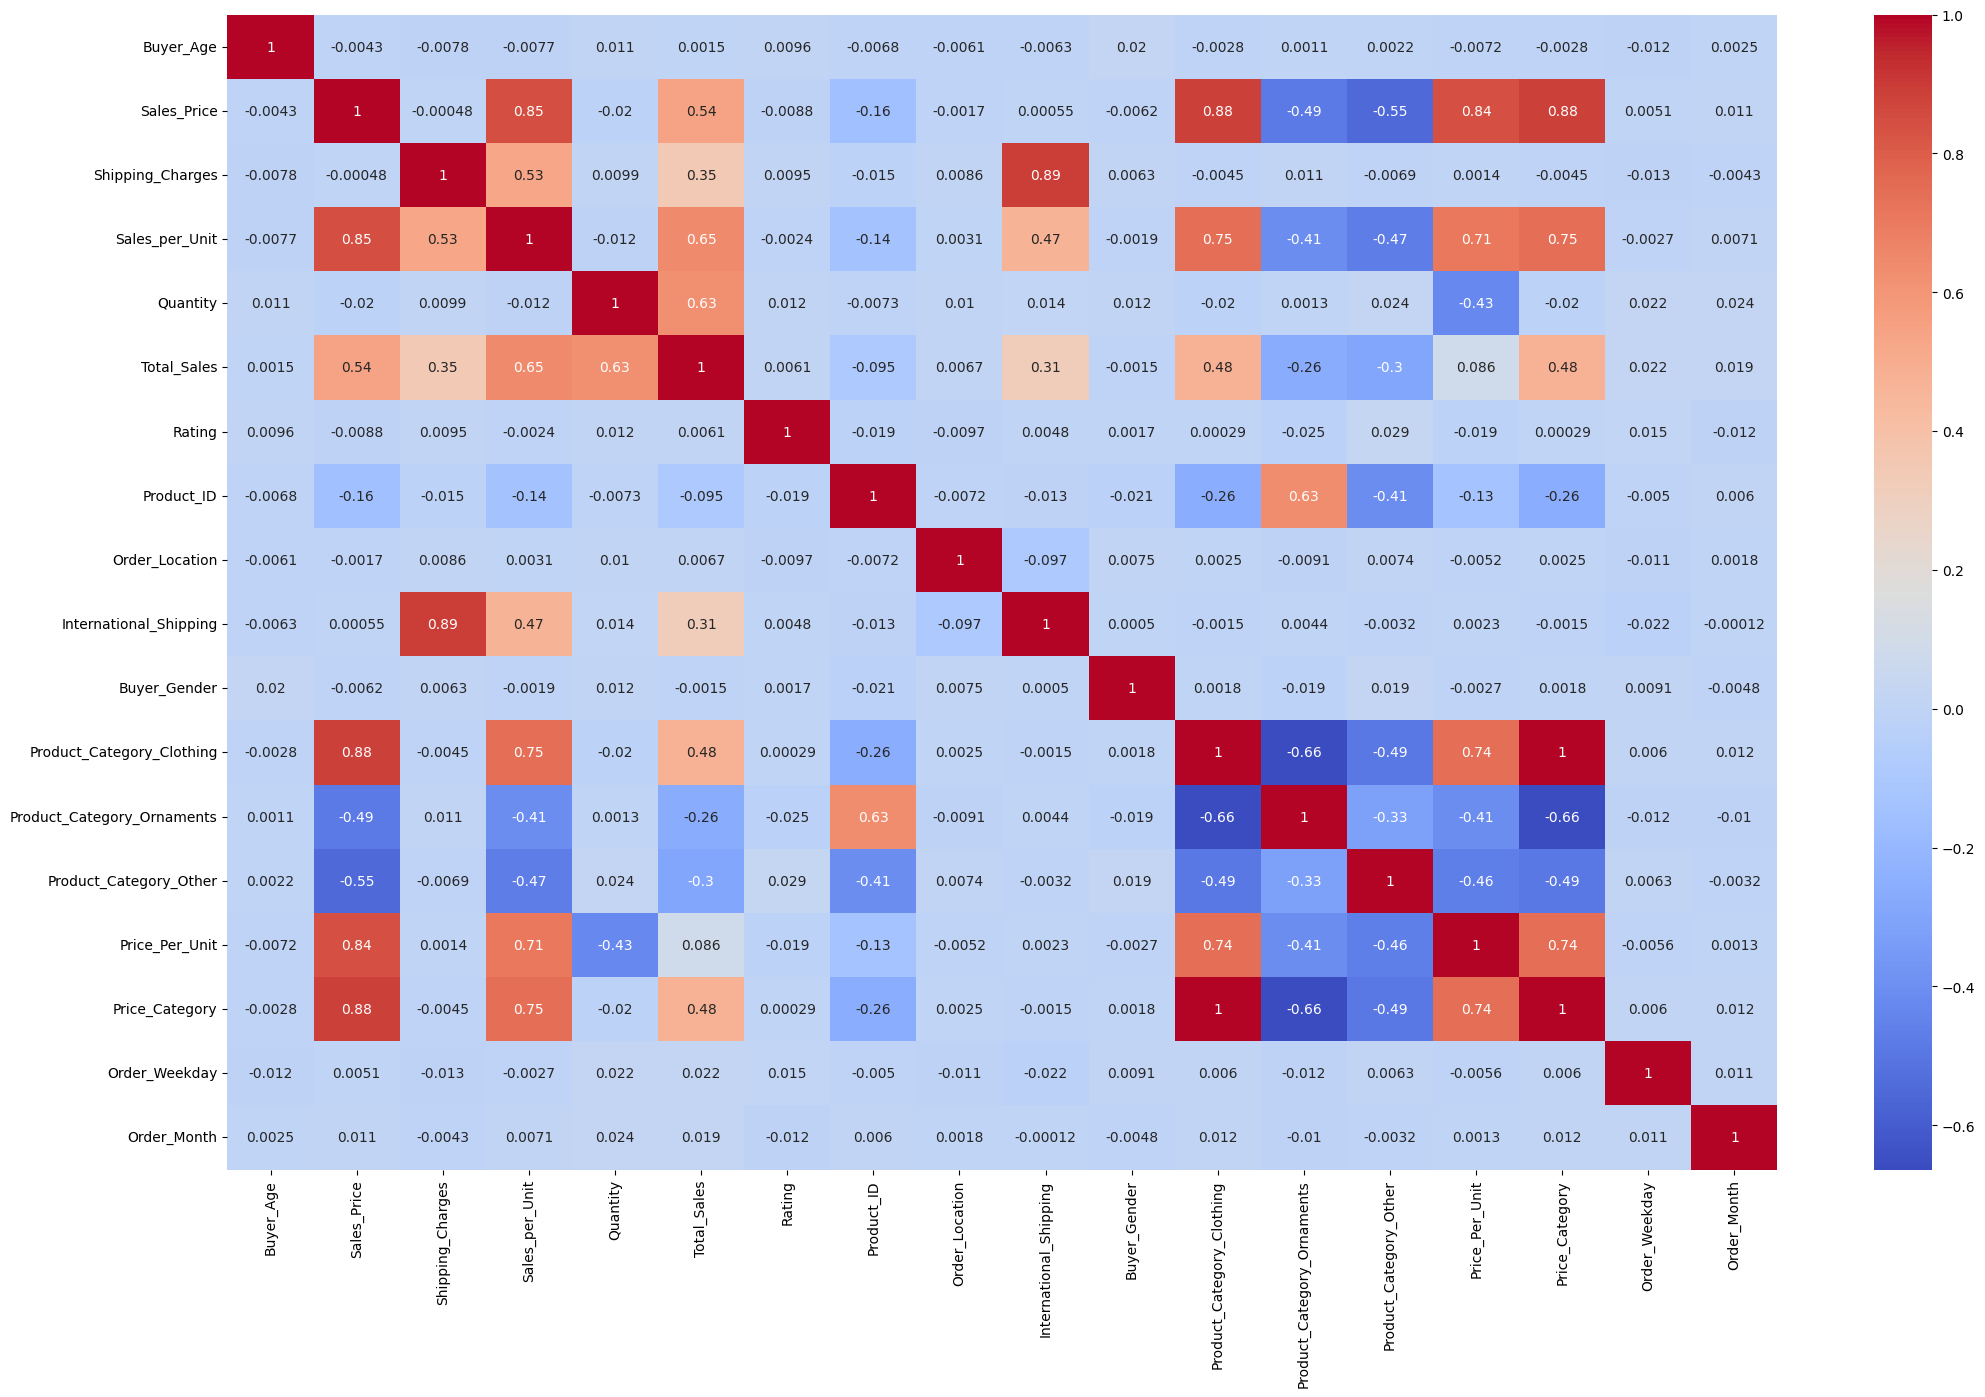

In [50]:
plt.figure(figsize=(25,15))

df_future = df.drop(columns='Order_Date')
corr = df_future.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm");

Tratando de hacer un poco de future engineer para ver si logramos encontrar variables con algo de relacion al genero del comprador. No ha sifo posible por el momento.

In [51]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=42)

In [52]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [53]:
rf = RandomForestClassifier(class_weight="balanced", random_state=42)
rf.fit(X_train, y_train)

pred_rf = rf.predict(X_test)
print(confusion_matrix(y_test, pred_rf))
print(classification_report(y_test, pred_rf))


[[ 81 386]
 [189 823]]
              precision    recall  f1-score   support

           0       0.30      0.17      0.22       467
           1       0.68      0.81      0.74      1012

    accuracy                           0.61      1479
   macro avg       0.49      0.49      0.48      1479
weighted avg       0.56      0.61      0.58      1479



In [54]:
log_model = LogisticRegression(C=1.0, random_state=1, class_weight="balanced")  # Balanceo de clases
log_model.fit(X_train, y_train)

pred_log = log_model.predict(X_test)
print(confusion_matrix(y_test,pred_log))
print(classification_report(y_test, pred_log))

[[238 229]
 [494 518]]
              precision    recall  f1-score   support

           0       0.33      0.51      0.40       467
           1       0.69      0.51      0.59      1012

    accuracy                           0.51      1479
   macro avg       0.51      0.51      0.49      1479
weighted avg       0.58      0.51      0.53      1479



In [55]:
xgb = XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=1,
    eval_metric='auc',
    use_label_encoder=False,
    random_state=42)

xgb.fit(X_train, y_train)

pred_xgb = rf.predict(X_test)
print(confusion_matrix(y_test, pred_xgb))
print(classification_report(y_test, pred_xgb))

[[ 81 386]
 [189 823]]
              precision    recall  f1-score   support

           0       0.30      0.17      0.22       467
           1       0.68      0.81      0.74      1012

    accuracy                           0.61      1479
   macro avg       0.49      0.49      0.48      1479
weighted avg       0.56      0.61      0.58      1479



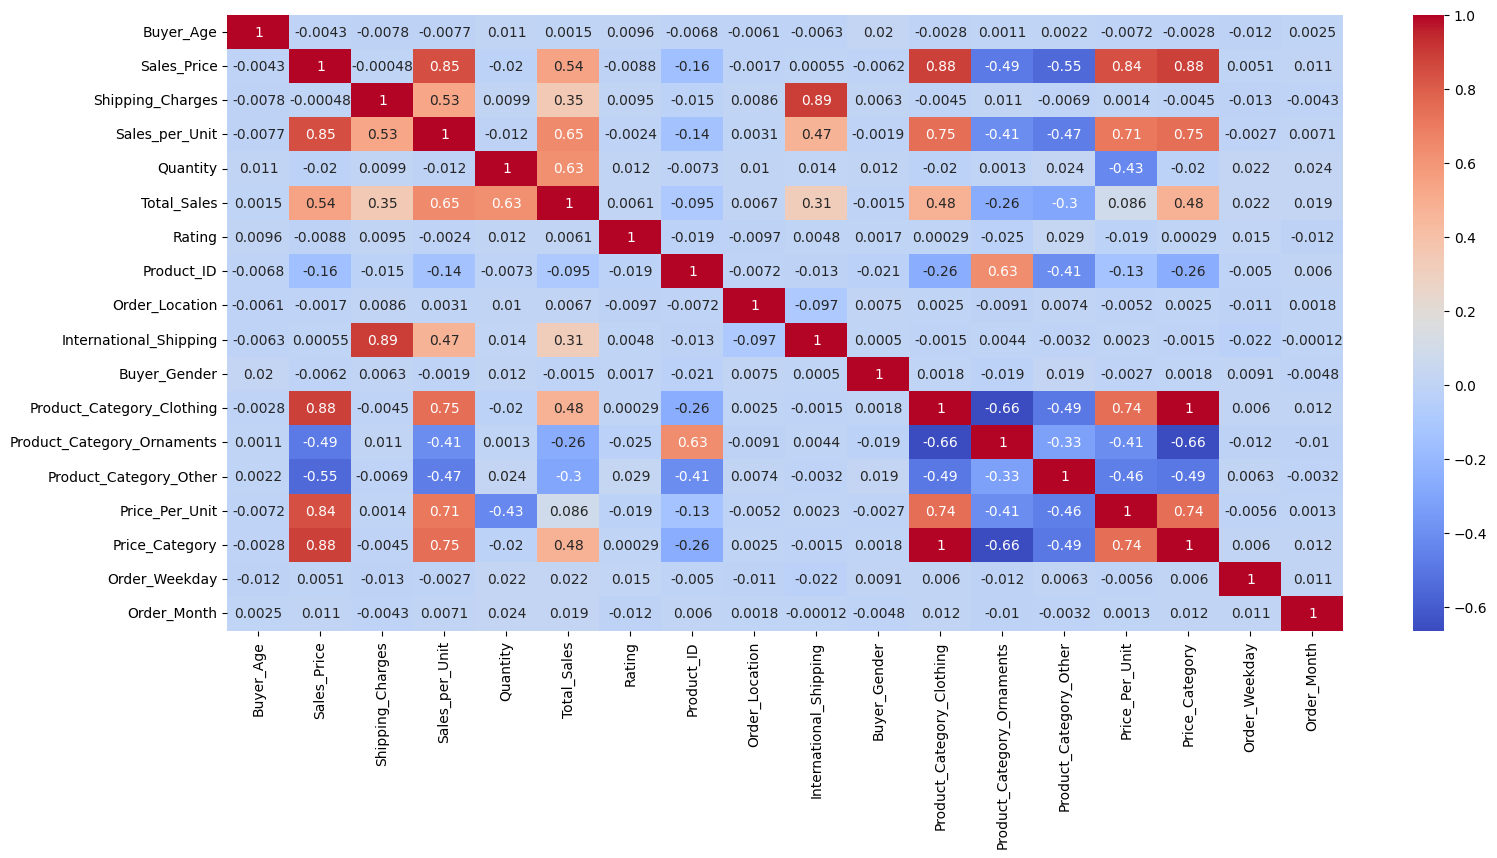

In [56]:
plt.figure(figsize=(18,8))

df_num = df.drop(columns='Order_Date')
corr = df_num.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm");

Observamos que no hay ninguna correlacion entre la target y las demas variables, por lo que dificulta enormemente realizar cualquier prediccion.

In [57]:
from tensorflow import keras
from keras import layers

In [58]:
model = keras.Sequential([

    layers.Dense(128, activation='relu',input_shape=(X_train.shape[1],)),
    layers.BatchNormalization(),
    layers.Dropout(0.30),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.30),
    layers.Dense(32,activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.30),
    layers.Dense(16, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.20),
    layers.Dense(1,activation='sigmoid')
    ])


model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])


In [59]:
model.summary();

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 128)            │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,633 (53.25 KB)

 Trainable params: 13,153 (51.38 KB)

 Non-trainable params: 480 (1.88 KB)

In [60]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                               patience=30,
                                               min_delta=0.01,
                                               restore_best_weights=True,
                                               )

reduce_lr = keras.callbacks.ReduceLROnPlateau(factor=0.2,
                                              patience=10,
                                              min_lr=0.00001,
                                              monitor='val_loss')

In [61]:
class_weights = {0: (len(y_train) / (2 * np.bincount(y_train)[0])), 
                 1: (len(y_train) / (2 * np.bincount(y_train)[1]))}


In [62]:
history = model.fit(X_train,
                    y_train,
                    validation_split=0.2,
                    epochs=100,
                    batch_size=32,
                    class_weight=class_weights
                    )

Epoch 1/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5053 - loss: 0.8708 - val_accuracy: 0.6348 - val_loss: 0.6622
Epoch 2/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5098 - loss: 0.7535 - val_accuracy: 0.6306 - val_loss: 0.6716
Epoch 3/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5229 - loss: 0.7278 - val_accuracy: 0.5376 - val_loss: 0.6875
Epoch 4/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5035 - loss: 0.7191 - val_accuracy: 0.4911 - val_loss: 0.6982
Epoch 5/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5050 - loss: 0.7175 - val_accuracy: 0.5038 - val_loss: 0.6932
Epoch 6/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5225 - loss: 0.7033 - val_accuracy: 0.5283 - val_loss: 0.6910
Epoch 7/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4975 - loss: 0.7072 - val_accuracy: 0.4768 - val_loss: 0.6982
Epoch 8/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5039 - loss: 0.7109 - val_accu

In [63]:
keras_pred = model.predict(X_test)

# Convertir probabilidades a 0 o 1 con umbral de 0.5
keras_pred_bin = (keras_pred > 0.5).astype(int)

# Evaluar con sklearn
print(confusion_matrix(y_test, keras_pred_bin))
print(classification_report(y_test, keras_pred_bin))


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[[204 263]
 [447 565]]
              precision    recall  f1-score   support

           0       0.31      0.44      0.36       467
           1       0.68      0.56      0.61      1012

    accuracy                           0.52      1479
   macro avg       0.50      0.50      0.49      1479
weighted avg       0.57      0.52      0.54      1479

